In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
                                        
%matplotlib inline

In [ ]:
from sklearn import datasets
import numpy as np
from statistics import mean

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models, Model 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import backend as K

### Create train and test sets from  Iris dataset

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :].astype('float32') 
y = iris.target.astype('float32')
y_onehot = to_categorical(y)

In [ ]:
X.shape

In [ ]:
y[0:5]

In [ ]:
y_onehot[0:5]

In [ ]:
x_train = X[:40]
y_train = list(y[:40])
y_train_onehot = y_onehot[:40]

for i in range(1,3):
    x_train = np.vstack((x_train, X[i*50:(i*50)+40]))
    y_train = y_train + list(y[i*50:(i*50)+40])
    y_train_onehot = np.vstack((y_train_onehot, y_onehot[i*50:(i*50)+40]))
print(x_train.shape, y_train_onehot.shape)

In [ ]:
x_test = X[40:50]
y_test = list(y[40:50])
y_test_onehot = y_onehot[40:50]

for i in range(1,3):
    x_test = np.vstack((x_test, X[(i*50)+40:(i*50)+40+10]))
    y_test = y_test + list(y[(i*50)+40:(i*50)+40+10])
    y_test_onehot = np.vstack((y_test_onehot, y_onehot[(i*50)+40:(i*50)+40+10]))
y_test = np.asarray(y_test)
print(x_test.shape, y_test.shape, y_test_onehot.shape)

### Networks and callbacks

In [10]:
input = layers.Input(shape=(4,), name='myInput')

In [11]:
batch_size = 15

In [12]:
#The selector layer that combines the expert and gate outputs. It is a non trainable layer
class selector_expectation(Layer):
    def __init__(self,num_experts, **kwargs):
        self.num_experts = num_experts
        super(selector_expectation,self).__init__(**kwargs)

    def build(self,input_shape):
        super(selector_expectation, self).build(input_shape)
        
    def call(self,input):

        x = input[0]
        p = input[1]
#         tf.print(K.shape(p))
        x = K.reshape(x,(batch_size, self.num_experts, 3))
#         tf.print('x:',x)
#         tf.print('p:',p)
        #Expected sum of the outputs of the experts
        output = K.sum(K.repeat_elements(K.reshape(p,(batch_size,self.num_experts,1)), rep=3,axis=2) * x, axis=1) 
#         tf.print('o:', output)
        return output
        
    def compute_output_shape(self,input_shape):
        return (input_shape[0],1,input_shape[-1])

    def get_config(self):
        return super(selector_expectation,self).get_config()


In [13]:
#Expert network
def expert_layers(input, output, name):
    x = layers.Dense(1000, activation='relu')(input)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(300,activation='relu')(x)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [14]:
#Gate network (Similar to the expert layer)
def gate_layers(input, output, name):
    x = layers.Dense(50, activation='relu')(input)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dense(10,activation='relu')(x)
    x = layers.Dense(output, activation='softmax',name=name)(x)
    return x

In [15]:
# Custom Model to intercept training to analyze the gradients during training
class CustomModel(Model):
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred)
            
        # Get the trainable weights
        trainable_gate_wts = [self.get_layer('dense').trainable_weights[0]]
        for i in range(1, 3):           
            trainable_gate_wts.append(self.get_layer('dense_'+str(i)).trainable_weights[0])
        trainable_gate_wts.append(self.get_layer('gate_layer').trainable_weights[0])
        
        gate_gradients = tape.gradient(loss, trainable_gate_wts)
        mean_abs_gradients = [ K.mean(K.abs(x)) for x in gate_gradients ]
        
        tf.print('\n', 'gate gradients:', mean_abs_gradients)
                   
        return super(CustomModel, self).train_step(data)

In [16]:
#Callback to track the loss and mean absolute activations of each expert during training
# and track the mean absolute activations of the gate network during training
class AnalysisCallback(Callback):
    
    def __init__(self, num_experts):
        self.expert_loss = {}
        self.expert_mean_abs_act = {}
        self.gate_mean_abs_act = []
        self.num_experts = num_experts
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        for i in range(1, self.num_experts+1):
            pred = self.model.get_layer('dense_'+str(i*3))(np.reshape(x_test[15],(1,4)), training = True)
            pred = self.model.get_layer('dense_'+str((i*3)+1))(pred, training = True)
            last_activation = self.model.get_layer('dense_'+str((i*3)+2))(pred, training = True)
            pred = self.model.get_layer('expert_'+str(i-1))(last_activation, training = True)
            loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15],(1,3)), pred))
            if self.expert_loss.get(i) is None:
                self.expert_loss[i] = []
            else:
                self.expert_loss[i].append(loss)
            if self.expert_mean_abs_act.get(i) is None:
                self.expert_mean_abs_act[i] = []
            else:
                self.expert_mean_abs_act[i].append(K.mean(K.abs(last_activation)))

        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training = True)
        pred = self.model.get_layer('dense_1')(pred, training = True)
        last_activation = self.model.get_layer('dense_2')(pred, training = True)
        pred = self.model.get_layer('gate_layer')(last_activation, training = True)
        self.gate_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        labels = []
        for i in range(1, self.num_experts+1):
            plt.plot(range(len(self.expert_loss[i])), self.expert_loss[i], label='expert '+str(i-1))
            labels.append('expert '+str(i-1))

        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        labels = []
        for i in range(1, self.num_experts+1):
            plt.plot(range(len(self.expert_mean_abs_act[i])), self.expert_mean_abs_act[i], label='expert '+str(i-1))
            labels.append('expert '+str(i-1))
            
        plt.plot(range(len( self.gate_mean_abs_act)), self.gate_mean_abs_act, label='gate')
        labels.append('gate')
        plt.legend(labels)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [17]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleModelCallback(Callback):
    def __init__(self):
        self.simple_model_loss = []
        self.simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training=True)
        pred = self.model.get_layer('dense_1')(pred, training=True)
        last_activation = self.model.get_layer('dense_2')(pred, training=True)
        pred = self.model.get_layer('simple_model')(last_activation, training=True)
        loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15],(1,3)), pred))
        self.simple_model_loss.append(loss)
        
#         print(self.model.get_layer('dense_5').get_weights()[0].shape)
        self.simple_model_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

In [18]:
#Callback for analysis a simple model to test the standalone expert model.
class SimpleGateCallback(Callback):
    
    def __init__(self):
        self.simple_model_loss = []
        self.simple_model_mean_abs_act = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.get_layer('dense')(np.reshape(x_test[15],(1,4)), training=True)
        pred = self.model.get_layer('dense_1')(pred, training=True)
        last_activation = self.model.get_layer('dense_2')(pred, training=True)
        pred = self.model.get_layer('simple_gate_output')(last_activation, training=True)
        loss = K.mean(categorical_crossentropy(np.reshape(y_test_onehot[15], (1,3)), pred))
        self.simple_model_loss.append(loss)
        
        self.simple_model_mean_abs_act.append(K.mean(K.abs(last_activation)))

    def on_train_end(self, logs=None):
        plt.plot(range(len(self.simple_model_loss)), self.simple_model_loss)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        
        plt.plot(range(len( self.simple_model_mean_abs_act)), self.simple_model_mean_abs_act)
        plt.xlabel('epochs')
        plt.ylabel('mean absolute activation')
        plt.show()
            

### Test the standalone expert model

In [19]:
K.clear_session()

In [20]:
simple_model_cb = SimpleModelCallback()

In [21]:
simple_model = Model(input, expert_layers(input, 3,'simple_model'))

In [22]:
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
simple_model (Dense)         (None, 3)                 903       
Total params: 656,703
Trainable params: 656,703
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
8/8 [==============================] - 0s 3ms/step - loss: 0.8632 - accuracy: 0.5750
Epoch 2/30
8/8 [==============================] - 0s 3ms/step - loss: 0.4113 - accuracy: 0.8083
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2646 - accuracy: 0.8917
Epoch 4/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2489 - accuracy: 0.8917
Epoch 5/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2629 - accuracy: 0.8667
Epoch 6/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9250
Epoch 7/30
8/8 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.9500
Epoch 8/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2694 - accuracy: 0.9000
Epoch 9/30
8/8 [==============================] - 0s 3ms/step - loss: 0.2955 - accuracy: 0.8583
Epoch 10/30
8/8 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8333
Epoch 11/30
8/8 [======================

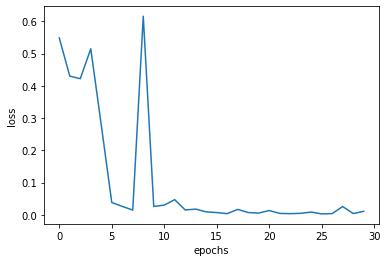

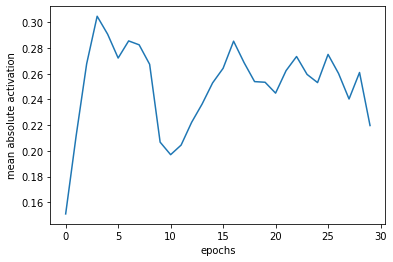

In [23]:
simple_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")
simple_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[simple_model_cb])

### Test the standalone gate network model

In [24]:
K.clear_session()

In [25]:
simple_gate_cb = SimpleGateCallback()

In [26]:
gate = gate_layers(input, 3, 'simple_gate_output')
gate_model = Model(input, gate, name='simple_gate_model' )

In [27]:
gate_model.summary()

Model: "simple_gate_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
simple_gate_output (Dense)   (None, 3)                 33        
Total params: 1,513
Trainable params: 1,513
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
8/8 [==============================] - 0s 1ms/step - loss: 1.1124 - categorical_accuracy: 0.6667
Epoch 2/30
8/8 [==============================] - 0s 1ms/step - loss: 1.0190 - categorical_accuracy: 0.6667
Epoch 3/30
8/8 [==============================] - 0s 1ms/step - loss: 0.9544 - categorical_accuracy: 0.6667
Epoch 4/30
8/8 [==============================] - 0s 1ms/step - loss: 0.9009 - categorical_accuracy: 0.6667
Epoch 5/30
8/8 [==============================] - 0s 1ms/step - loss: 0.8479 - categorical_accuracy: 0.6667
Epoch 6/30
8/8 [==============================] - 0s 1ms/step - loss: 0.7965 - categorical_accuracy: 0.7333
Epoch 7/30
8/8 [==============================] - 0s 2ms/step - loss: 0.7440 - categorical_accuracy: 0.8417
Epoch 8/30
8/8 [==============================] - 0s 1ms/step - loss: 0.6951 - categorical_accuracy: 0.8583
Epoch 9/30
8/8 [==============================] - 0s 1ms/step - loss: 0.6460 - categorical_accuracy: 0.8417
Epoch 10/30
8/8 [===========

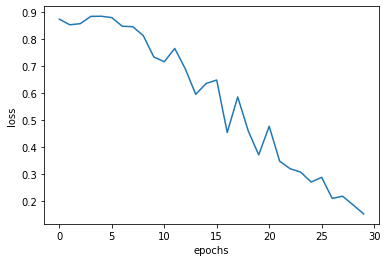

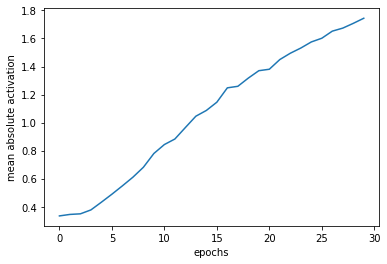

In [28]:
gate_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["categorical_accuracy"])
gate_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[simple_gate_cb])

### Mixture of experts model

In [29]:
K.clear_session()

In [30]:
num_experts = 5

In [31]:
#Initialize gate network
gate = gate_layers(input, num_experts, 'gate_layer')

In [32]:
#Initialize expert networks
experts = []
for i in range(num_experts):
    experts.append(expert_layers(input, 3, 'expert_'+str(i)))

In [33]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts, trainable=False)([expert_output, gate])

In [34]:
selector_model = CustomModel(input, selector_output,name='selector')

In [35]:
selector_model.summary()

Model: "selector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
myInput (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
___________________________________________________________________________________________

In [36]:
selector_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="categorical_accuracy")

In [37]:
analysis_cb = AnalysisCallback(num_experts)

Epoch 1/30

 gate gradients: [0.000535757106, 0.000229827245, 0.000242147711, 0.000469405379]
1/8 [==>...........................] - ETA: 0s - loss: 1.1212 - accuracy: 0.3333
 gate gradients: [0.00171187834, 0.000751980173, 0.000788707111, 0.00275968551]

 gate gradients: [0.000917183235, 0.000347549387, 0.00028796625, 0.000938509824]

 gate gradients: [0.0137914391, 0.00571213337, 0.00619650353, 0.0114387991]

 gate gradients: [0.011299883, 0.00514806947, 0.0054710228, 0.0108631989]
5/8 [=================>............] - ETA: 0s - loss: 1.4312 - accuracy: 0.4667
 gate gradients: [0.00424903, 0.00181274698, 0.00168025855, 0.00499550113]

 gate gradients: [0.00758347847, 0.00346288388, 0.00339670363, 0.00799630489]

 gate gradients: [0.00150068756, 0.000610615942, 0.000587031187, 0.00110002456]
8/8 [==============================] - 0s 13ms/step - loss: 1.5300 - accuracy: 0.3833
Epoch 2/30

 gate gradients: [0.00179304148, 0.000784499047, 0.000974353577, 0.00350816105]
1/8 [==>.........

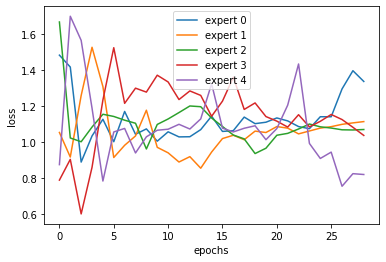

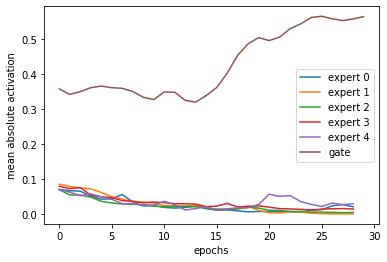

In [38]:
selector_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[analysis_cb])

### Comparing activations of standalone expert network to an expert of MOE

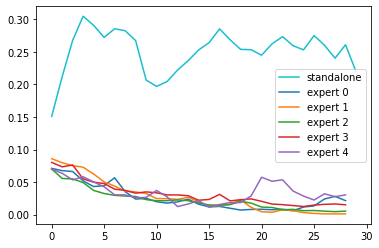

In [51]:
plt.plot(range(len( simple_model_cb.simple_model_mean_abs_act)), simple_model_cb.simple_model_mean_abs_act,color='tab:cyan')
labels = ['standalone']
for key, expert in analysis_cb.expert_mean_abs_act.items():
    plt.plot(range(len( analysis_cb.expert_mean_abs_act[key])), analysis_cb.expert_mean_abs_act[key])
    labels.append('expert '+ str(key-1))
plt.legend(labels)
plt.show()

### Comparing predictions of standalone expert network with the predictions of the MOE network

In [40]:
pred = simple_model.predict(x_test, batch_size=batch_size)
pred

array([[9.9995100e-01, 4.8997714e-05, 4.3645927e-11],
       [9.9818498e-01, 1.8150018e-03, 3.2020356e-08],
       [9.9984288e-01, 1.5714245e-04, 6.0299776e-10],
       [9.9977773e-01, 2.2226646e-04, 6.2516131e-10],
       [9.9980456e-01, 1.9548766e-04, 3.0554004e-10],
       [9.9971801e-01, 2.8196684e-04, 1.0215351e-09],
       [9.9994981e-01, 5.0139752e-05, 3.0488216e-11],
       [9.9982160e-01, 1.7844069e-04, 5.5356758e-10],
       [9.9996245e-01, 3.7509497e-05, 1.5410666e-11],
       [9.9990499e-01, 9.5008079e-05, 1.1477211e-10],
       [4.9656129e-04, 9.4415057e-01, 5.5352829e-02],
       [3.7920719e-04, 9.9276191e-01, 6.8589142e-03],
       [1.1907499e-03, 9.9718910e-01, 1.6201412e-03],
       [5.4874453e-03, 9.9327469e-01, 1.2378071e-03],
       [7.5501559e-04, 9.8994863e-01, 9.2962915e-03],
       [1.2273084e-03, 9.9721730e-01, 1.5554180e-03],
       [9.6720539e-04, 9.9586344e-01, 3.1693489e-03],
       [7.5004058e-04, 9.9823904e-01, 1.0108504e-03],
       [4.5642834e-02, 9.539

In [41]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [42]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)

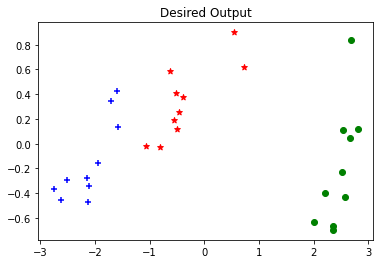

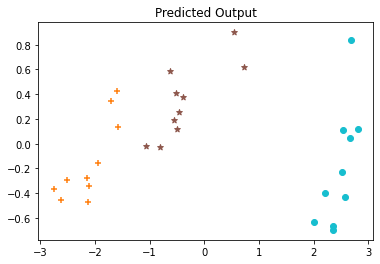

In [43]:
# PCA projection of actual and predicted targets with standalone expert
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

In [44]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

array([[0.32325915, 0.33911827, 0.33762264],
       [0.32354766, 0.33902553, 0.3374268 ],
       [0.32266665, 0.33999217, 0.33734122],
       [0.32529214, 0.3434293 , 0.3312786 ],
       [0.32530725, 0.34278634, 0.33190632],
       [0.33188245, 0.32632843, 0.34178913],
       [0.33144665, 0.32680342, 0.34174994],
       [0.33151338, 0.32504007, 0.34344655],
       [0.32917523, 0.34243542, 0.32838938],
       [0.32958066, 0.3414886 , 0.32893077],
       [0.5258308 , 0.226255  , 0.24791425],
       [0.52532524, 0.22735931, 0.24731548],
       [0.5595927 , 0.20741658, 0.23299062],
       [0.32336557, 0.34142303, 0.33521137],
       [0.3233549 , 0.34200284, 0.33464223],
       [0.32509193, 0.34312865, 0.33177948],
       [0.32582694, 0.34532928, 0.32884374],
       [0.32583135, 0.34562758, 0.3285411 ],
       [0.32574886, 0.34433076, 0.3299204 ],
       [0.32566902, 0.34406346, 0.3302675 ],
       [0.32883304, 0.34111816, 0.33004874],
       [0.3298628 , 0.34640226, 0.32373485],
       [0.

In [45]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 2, 2, 2, 2])

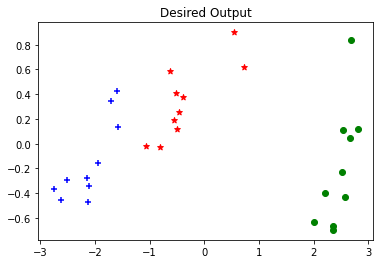

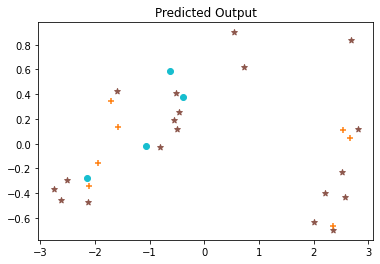

In [46]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()

### Mixture of Experts model with the gate output fixed at [1,0,0]

In [47]:
K.clear_session()

In [48]:
#Gate network (Similar to the expert layer) with a fixed output of [1, 0, 0]
def gate_layers_fixed(input, output, name):
    x = layers.Dense(1000, activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(input)
    x = layers.Dense(500, activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(300,activation='relu', kernel_initializer=initializers.Zeros(), 
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(output, activation='softmax',name=name, kernel_initializer=initializers.Zeros(), 
                     bias_initializer=tf.constant_initializer([3.]+[0.]*(output-1)))(x)
    return x

In [49]:
num_experts = 3

In [50]:
#Initialize gate network
gate = gate_layers_fixed(input, num_experts, 'gate_layer')

In [51]:
#Initialize expert networks
experts = []
for i in range(num_experts):
    experts.append(expert_layers(input, 3, 'expert_'+str(i)))

In [52]:
# Initialize the selector network
expert_output = experts[0]
if num_experts > 1:
    expert_output = tf.keras.layers.Concatenate(axis=0)(experts)
selector_output = selector_expectation(num_experts=num_experts, trainable=False)([expert_output, gate])

In [53]:
selector_model = CustomModel(input, selector_output,name='selector')

In [54]:
selector_model.summary()

Model: "selector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
myInput (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1000)         5000        myInput[0][0]                    
___________________________________________________________________________________________

In [55]:
selector_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics="accuracy")

In [56]:
analysis_cb = AnalysisCallback(num_experts)

Epoch 1/30

 gate gradients: [0, 0, 0, 0]
1/8 [==>...........................] - ETA: 0s - loss: 1.1827 - accuracy: 0.1333
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
5/8 [=================>............] - ETA: 0s - loss: 1.3518 - accuracy: 0.1867
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
8/8 [==============================] - 0s 16ms/step - loss: 1.3359 - accuracy: 0.2083
Epoch 2/30

 gate gradients: [0, 0, 0, 0]
1/8 [==>...........................] - ETA: 0s - loss: 1.0233 - accuracy: 0.5333
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
5/8 [=================>............] - ETA: 0s - loss: 1.1110 - accuracy: 0.3867
 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]

 gate gradients: [0, 0, 0, 0]
8/8 [==============================] - 0s 14ms/step - loss: 1.1478 - accurac

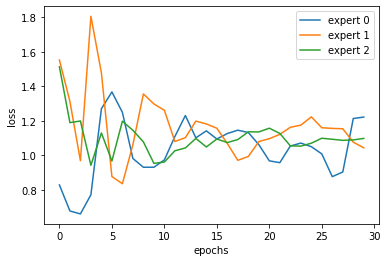

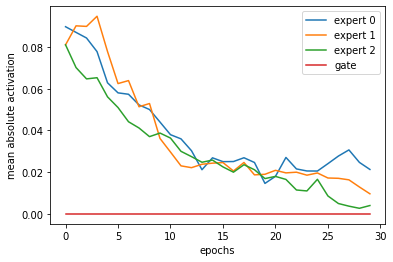

In [57]:
selector_model.fit(x_train, y_train_onehot, epochs=30, batch_size=batch_size, shuffle=True, callbacks=[analysis_cb])

In [58]:
pred = selector_model.predict(x_test, batch_size=batch_size)
pred

array([[0.5036213 , 0.22748919, 0.26888955],
       [0.4897263 , 0.2348408 , 0.275433  ],
       [0.50914353, 0.22408168, 0.26677477],
       [0.4876601 , 0.23633476, 0.2760052 ],
       [0.37864298, 0.29852012, 0.32283694],
       [0.3305694 , 0.34487945, 0.32455122],
       [0.3295357 , 0.34553766, 0.32492667],
       [0.33050898, 0.34520394, 0.32428715],
       [0.329572  , 0.34579596, 0.32463217],
       [0.32259557, 0.3521738 , 0.32523072],
       [0.32512197, 0.3378158 , 0.33706227],
       [0.32590586, 0.336616  , 0.33747822],
       [0.3253172 , 0.33779538, 0.33688745],
       [0.32551253, 0.33714473, 0.33734286],
       [0.32806513, 0.33340523, 0.33852974],
       [0.38316384, 0.29480523, 0.322031  ],
       [0.39233434, 0.28910276, 0.318563  ],
       [0.36651212, 0.3014925 , 0.33199546],
       [0.35715184, 0.30427694, 0.33857128],
       [0.3609058 , 0.30468172, 0.33441257],
       [0.32234237, 0.35223144, 0.3254263 ],
       [0.32402965, 0.34999943, 0.325971  ],
       [0.

In [59]:
pred = np.asarray([np.argmax(pred[i]) for i in range(len(pred))])
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2])

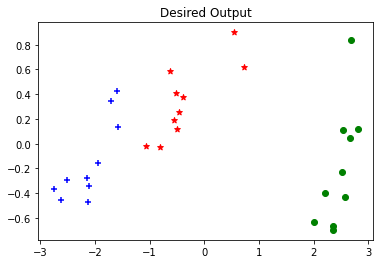

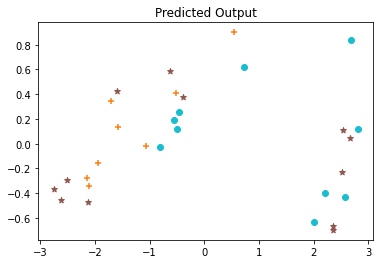

In [60]:
# PCA projection of actual and predicted targets with MOE
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
coord = pca.fit_transform(x_test)

markers = ['o','*','+']
colors0 = ['g', 'r', 'b']
colors1 = ['tab:cyan', 'tab:brown', 'tab:orange']
for i in range(3):
    plt.scatter(coord[y_test == i,0], coord[y_test == i, 1],color=colors0[i], marker=markers[i])
plt.title('Desired Output')
plt.show()
for i in range(3):
    plt.scatter(coord[pred == i,0], coord[pred == i, 1],color=colors1[i], marker=markers[i])
plt.title('Predicted Output')
plt.show()